In [1]:
import scanpy as sc
import scvi
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
sc.set_figure_params(figsize=(4, 4))

/Users/leanderdiaz-bone/Developer/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/leanderdiaz-bone/Developer/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
adata = scvi.data.heart_cell_atlas_subsampled()
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [3]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [5]:
def trainModel(adata,prior,max_epochs,freq=5,save=None, prior_kwargs=None):
    model = scvi.model.SCVI(adata,prior_distribution=prior, prior_kwargs=prior_kwargs)
    model.train(max_epochs=max_epochs,check_val_every_n_epoch=freq)
    if save != None:
        model.save(save)
    return model

In [6]:
def umapVisualization(model, adata):
    warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
    adata.obsm["X_scVI"] = model.get_latent_representation()
    adata_subset = adata[adata.obs.cell_type == "Fibroblast"]
    latent_subset = model.get_latent_representation(adata_subset)
    denoised = model.get_normalized_expression(adata_subset, library_size=1e4)
    denoised.iloc[:5, :5]
    adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=10e4)
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.3)
    sc.pl.umap(
        adata,
        color=["cell_type"],
        frameon=False,
    )
    sc.pl.umap(
        adata,
        color=["donor", "cell_source"],
        ncols=2,
        frameon=False,
    )


In [ ]:
def plotTrainingHistory(model):
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotReconstructionLoss(model):
    train_elbo = model.history["reconstruction_loss_train"][1:]
    test_elbo = model.history["reconstruction_loss_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotKLLocalLoss(model):
    train_elbo = model.history["kl_local_train"][1:]
    test_elbo = model.history["kl_local_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

def plotKLGlobalLoss(model):
    train_elbo = model.history["kl_global_train"][1:]
    test_elbo = model.history["kl_global_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)

In [ ]:
model1 = trainModel(adata,"sdnormal",100,"models/viscells_sdnormal")

In [19]:
model1 = scvi.model.SCVI.load("models/viscells_sdnormal", adata=adata)

INFO     File models/viscells_sdnormal/model.pt already downloaded                                                 
New version.


In [ ]:
umapVisualization(model1, adata)

In [ ]:
model2 = trainModel(adata,"normal",100,"models/viscells_normal")

INFO     File models/viscells_normal/model.pt already downloaded                                                   
New version.
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


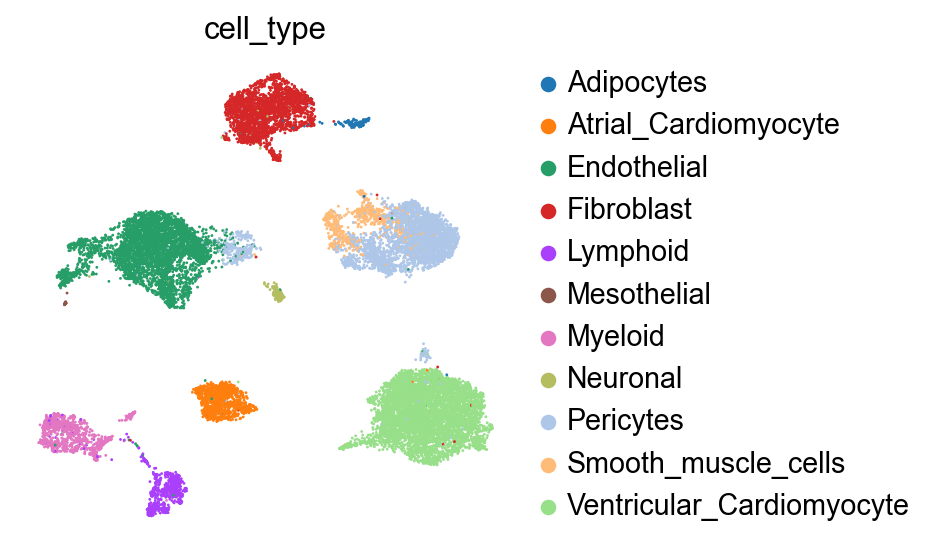

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


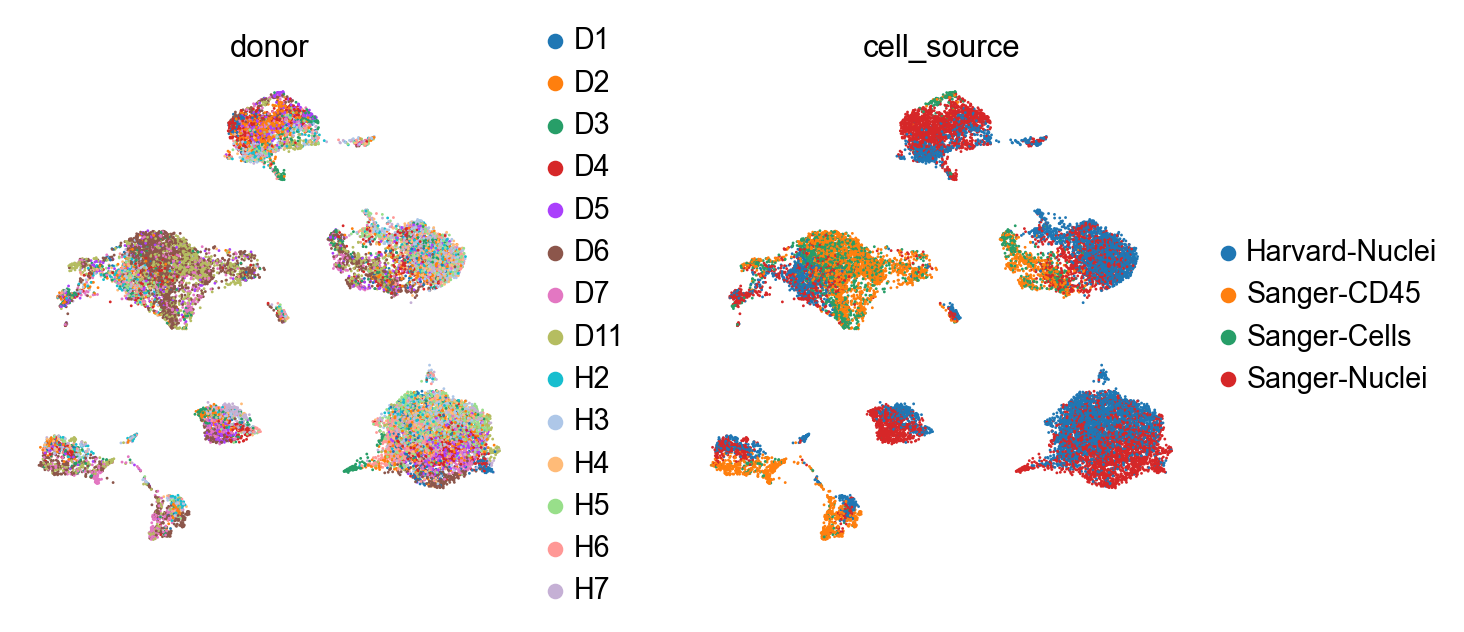

In [17]:
model2 = scvi.model.SCVI.load("models/viscells_normal", adata=adata)
umapVisualization(model1, adata)

In [ ]:
model3 = trainModel(adata,"vamp",100,"models/viscells_vamp")

In [16]:
model3 = scvi.model.SCVI.load("models/vamp200", adata=adata)

INFO     File models/vamp200/model.pt already downloaded                                                           


In [ ]:
umapVisualization(model3, adata)

In [13]:
modelsd = trainModel(adata, "sdnormal", 50, freq = 5)

New version.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 50/50: 100%|██████████| 50/50 [03:39<00:00,  5.06s/it, v_num=1, train_loss_step=293, train_loss_epoch=278]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, v_num=1, train_loss_step=293, train_loss_epoch=278]


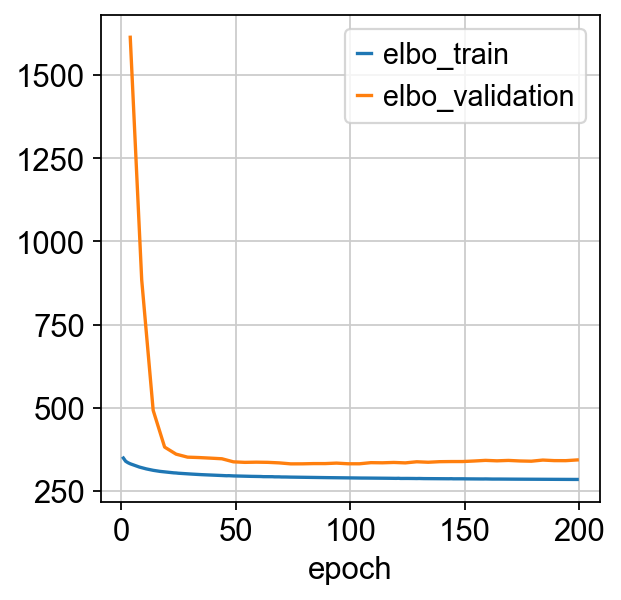

In [17]:
plotTrainingHistory(model3)

In [23]:
modelno = trainModel(adata, "normal", 50, freq = 5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


New version.
Epoch 50/50: 100%|██████████| 50/50 [03:30<00:00,  4.51s/it, v_num=1, train_loss_step=312, train_loss_epoch=278]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [03:30<00:00,  4.21s/it, v_num=1, train_loss_step=312, train_loss_epoch=278]


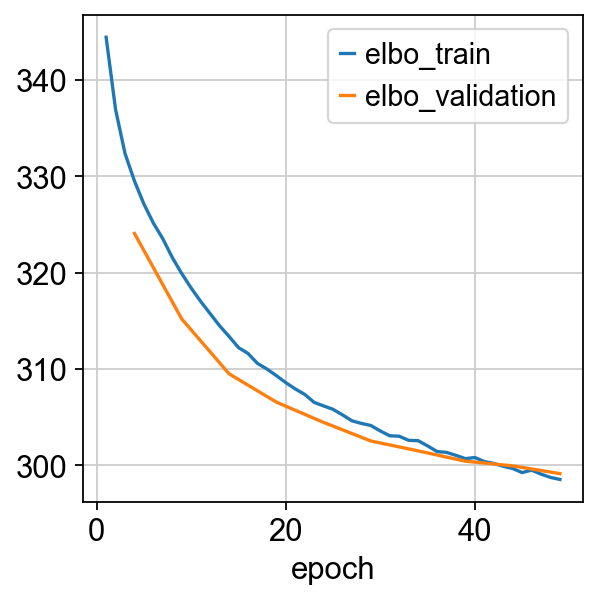

In [24]:
plotTrainingHistory(modelno)

In [17]:
modelva = trainModel(adata, "vamp", 50, freq = 5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


New version.
Epoch 50/50: 100%|██████████| 50/50 [06:27<00:00,  7.27s/it, v_num=1, train_loss_step=291, train_loss_epoch=277]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [06:27<00:00,  7.76s/it, v_num=1, train_loss_step=291, train_loss_epoch=277]


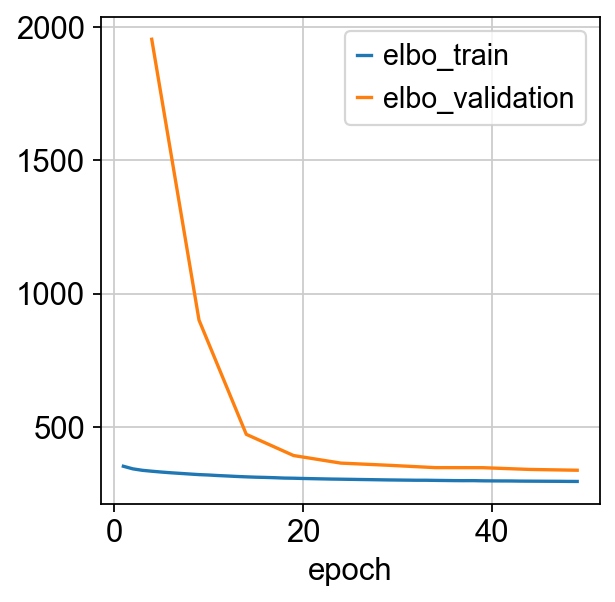

In [18]:
plotTrainingHistory(modelva)

In [8]:
model3.module.prior.description()

'Vamp Prior with pseudo inputs: tensor([[1., 0., 0.,  ..., 0., 0., 0.],\n        [0., 1., 0.,  ..., 0., 0., 0.],\n        [0., 0., 1.,  ..., 0., 0., 0.],\n        ...,\n        [0., 0., 0.,  ..., 1., 0., 0.],\n        [0., 0., 0.,  ..., 0., 1., 0.],\n        [0., 0., 0.,  ..., 0., 0., 1.]]) and mixing parameter : Parameter containing:\ntensor([ 4.6805e-01,  3.4682e-01,  3.2124e-01, -7.4674e-03, -2.6672e-01,\n        -2.9593e-01,  4.0661e-01, -2.9594e-01,  1.3427e-01, -2.9594e-01,\n         8.3897e-02,  4.1393e-01, -2.9593e-01, -2.9594e-01,  3.8450e-01,\n        -2.9594e-01,  1.0708e+00,  1.2431e-01, -2.9592e-01,  2.1327e-01,\n        -2.9594e-01, -2.9594e-01, -2.9594e-01,  2.7534e-01,  2.3634e-02,\n        -2.7102e-01, -2.9594e-01, -2.9594e-01,  6.7032e-02,  1.0095e-01,\n        -2.9590e-01,  1.5972e-01,  3.4156e-01, -2.9592e-01,  5.8556e-02,\n         3.2921e-01, -2.9590e-01,  1.8358e-01, -2.9594e-01, -2.9594e-01,\n         4.8515e-01, -2.9591e-01,  3.3185e-02, -2.9593e-01,  2.3237e-0

In [11]:
psi, (norm, _) = model3.module.prior.get_pseudo_inputs()

In [17]:
norm.loc

tensor([[ 0.7969, -0.5857,  0.2766,  ...,  0.1433,  0.2129,  0.2743],
        [ 0.7286, -0.4742,  0.0064,  ..., -0.0526,  0.2000,  0.1492],
        [ 0.6893, -0.4521,  0.0571,  ...,  0.2203,  0.1984,  0.2956],
        ...,
        [ 0.9155, -0.3810,  0.0997,  ...,  0.2140,  0.2636,  0.2620],
        [ 0.9537, -0.5657,  0.0224,  ...,  0.2684,  0.2246,  0.3828],
        [ 0.6259, -0.4375,  0.2257,  ...,  0.1979,  0.1318,  0.2567]],
       grad_fn=<AddmmBackward0>)

In [15]:
norm.scale

tensor([[0.3279, 0.3303, 0.3138,  ..., 0.3111, 0.3431, 0.3190],
        [0.3490, 0.3492, 0.3376,  ..., 0.3206, 0.3636, 0.3316],
        [0.3318, 0.3363, 0.3278,  ..., 0.3230, 0.3522, 0.3275],
        ...,
        [0.2547, 0.2505, 0.2428,  ..., 0.2423, 0.2647, 0.2398],
        [0.2406, 0.2393, 0.2289,  ..., 0.2300, 0.2510, 0.2293],
        [0.3229, 0.3293, 0.3189,  ..., 0.3162, 0.3458, 0.3194]],
       grad_fn=<SqrtBackward0>)

In [20]:
model1.module.prior.description()

'Gaussian Prior with mean: Parameter containing:\ntensor([-0.0100, -0.2908,  0.1746,  0.4191,  0.1110,  0.1139, -0.0627, -0.0493,\n        -0.2043, -0.1034], requires_grad=True) and log variance: Parameter containing:\ntensor([0.8959, 0.9932, 1.2560, 1.4170, 1.0818, 0.9188, 0.9238, 1.0425, 1.5210,\n        1.0901], requires_grad=True)'

In [31]:
modeltest1 = trainModel(adata, "sdnormal", 3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


New version.
Epoch 3/3: 100%|██████████| 3/3 [00:12<00:00,  4.30s/it, v_num=1, train_loss_step=443, train_loss_epoch=306]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [00:12<00:00,  4.27s/it, v_num=1, train_loss_step=443, train_loss_epoch=306]


In [32]:
modeltest2 = trainModel(adata, "vamp", 3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


New version.
Epoch 3/3: 100%|██████████| 3/3 [00:20<00:00,  6.87s/it, v_num=1, train_loss_step=285, train_loss_epoch=306]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [00:20<00:00,  6.80s/it, v_num=1, train_loss_step=285, train_loss_epoch=306]


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


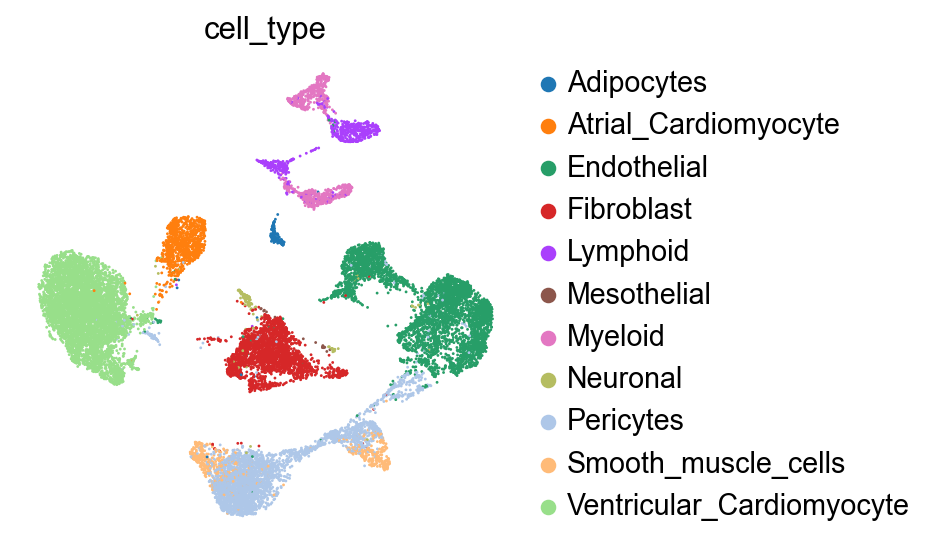

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


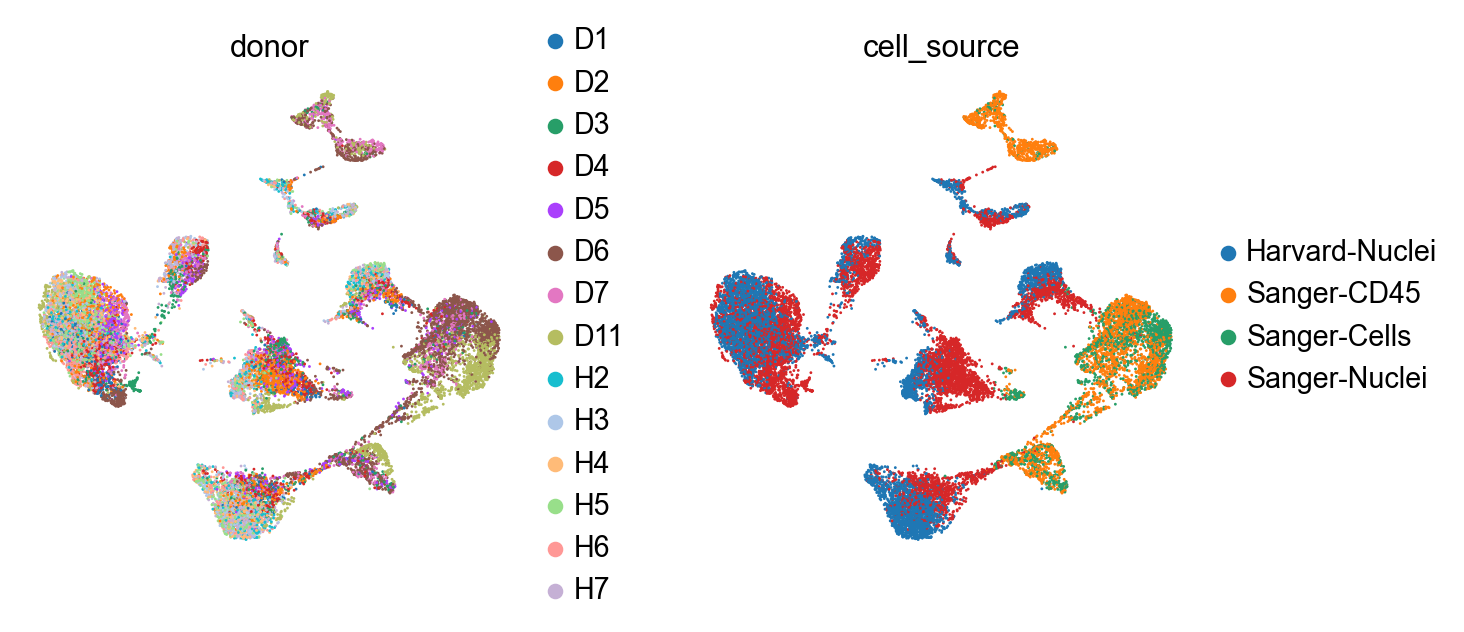

In [33]:
umapVisualization(modeltest1, adata)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


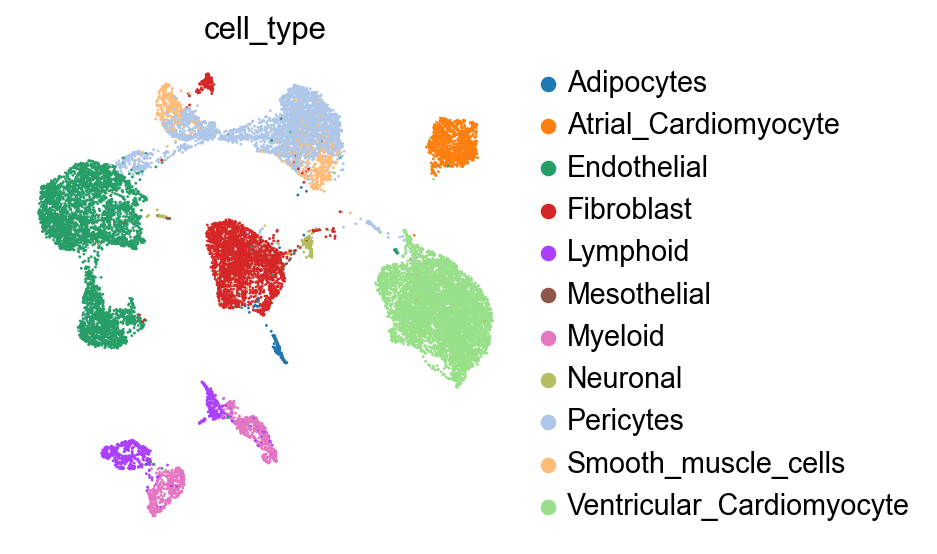

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


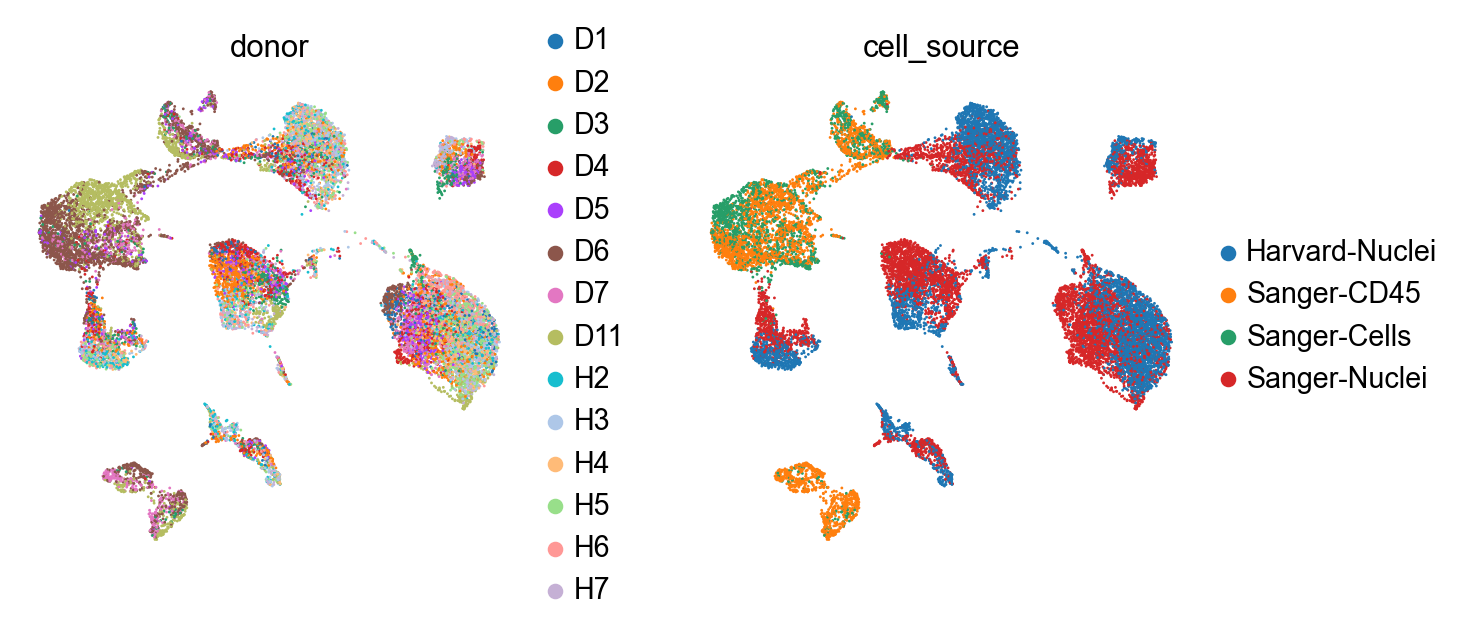

In [34]:
umapVisualization(modeltest2, adata)

In [35]:
modelvamp = trainModel(adata, "vamp", max_epochs=200, save="models/vamp200")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


New version.
Epoch 200/200: 100%|██████████| 200/200 [23:53<00:00,  7.16s/it, v_num=1, train_loss_step=259, train_loss_epoch=278]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [23:53<00:00,  7.17s/it, v_num=1, train_loss_step=259, train_loss_epoch=278]


In [52]:
modelsdpr = trainModel(adata, "sdnormal", max_epochs=200, save="models/sdprior200")

New version.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [13:07<00:00,  4.43s/it, v_num=1, train_loss_step=274, train_loss_epoch=280]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [13:07<00:00,  3.94s/it, v_num=1, train_loss_step=274, train_loss_epoch=280]


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


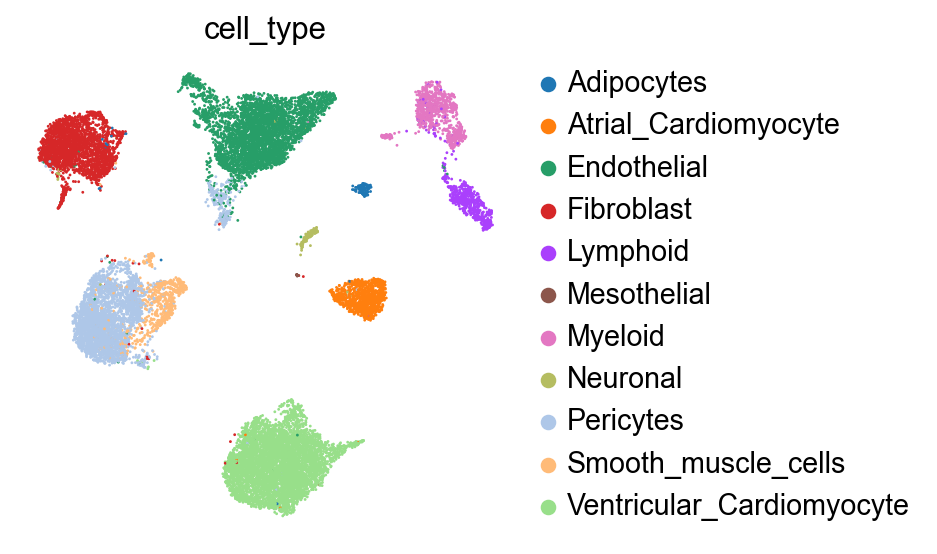

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


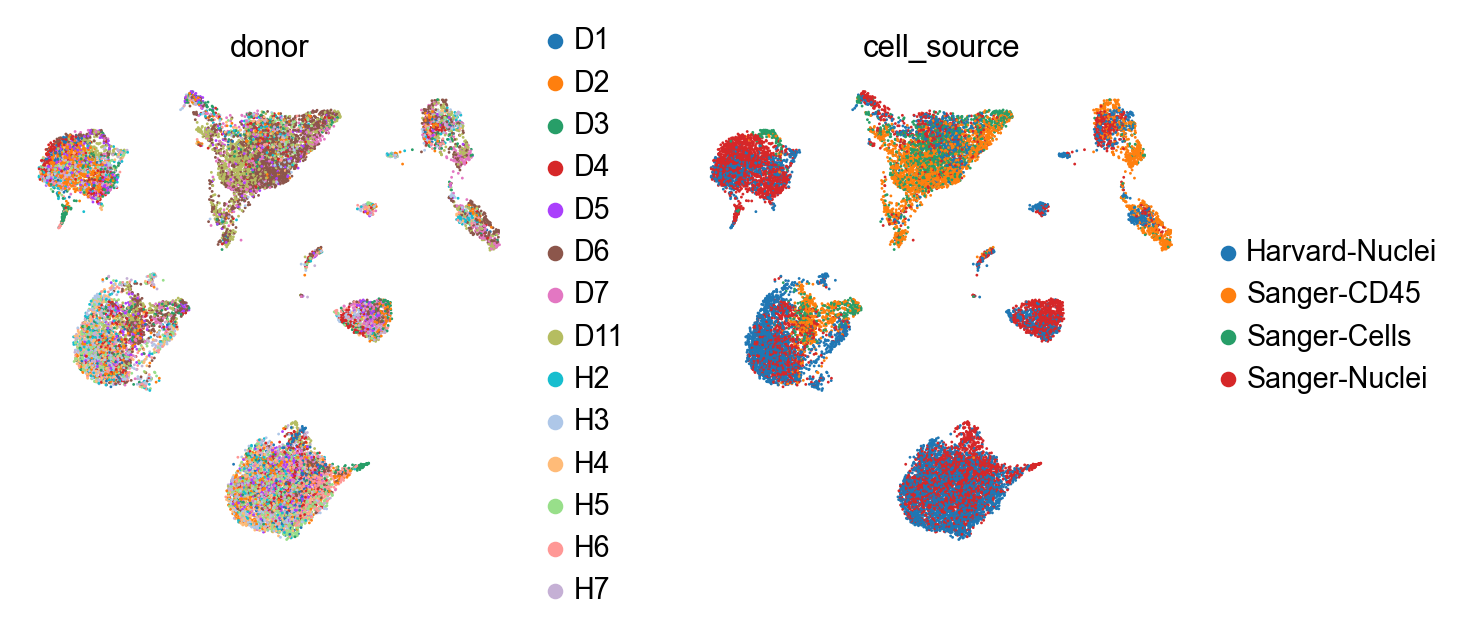

In [36]:
umapVisualization(modelvamp, adata)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


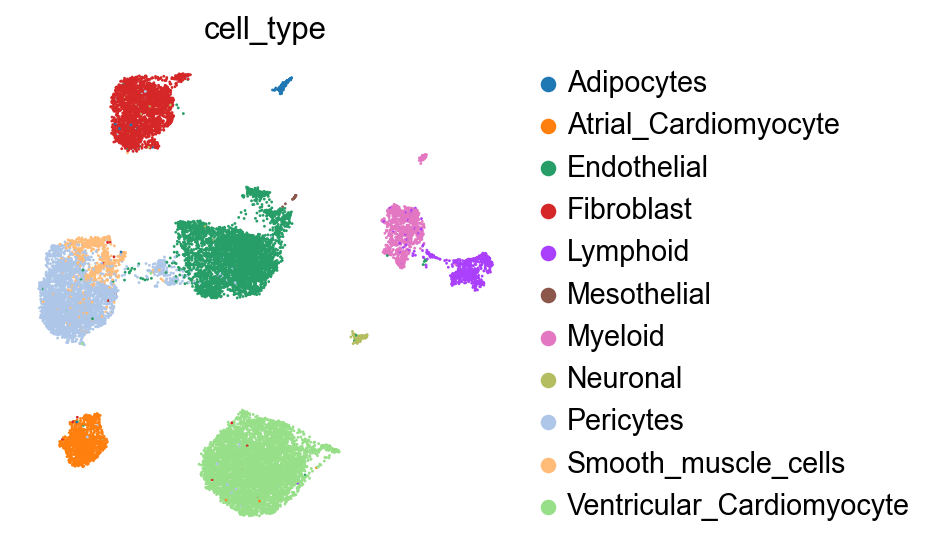

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


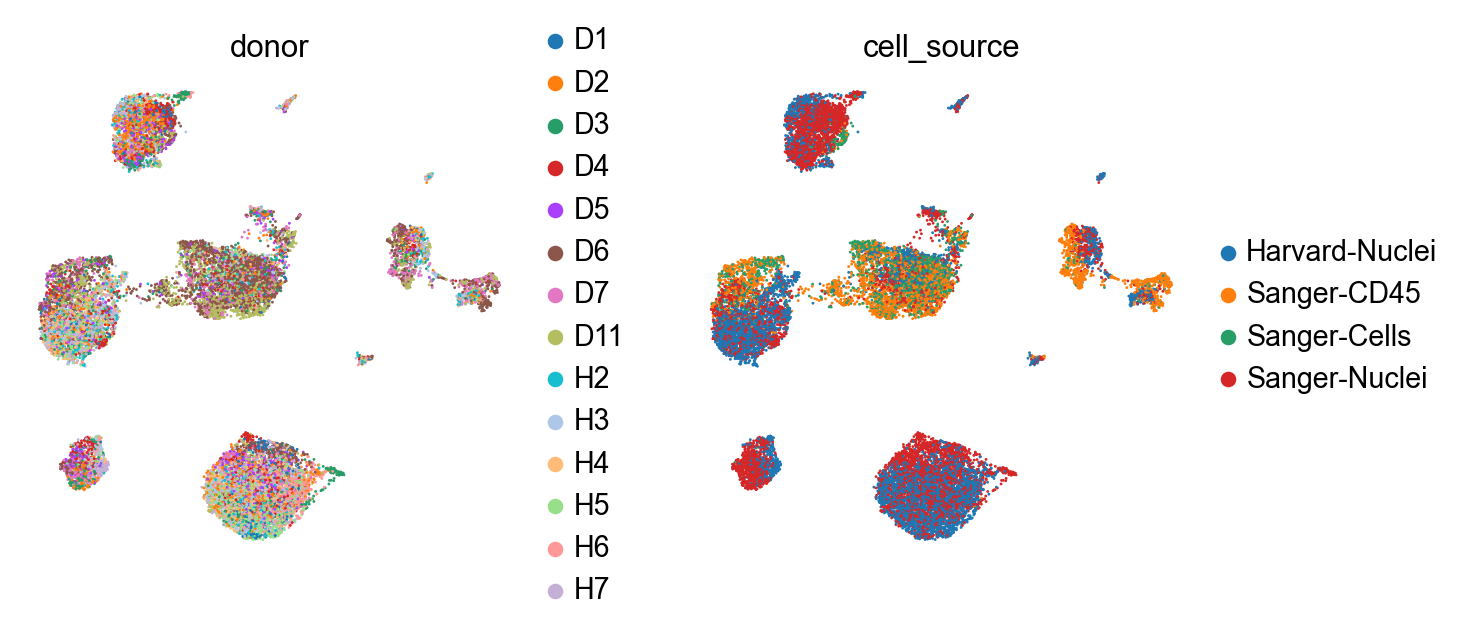

In [59]:
umapVisualization(modelsdpr,adata)

In [42]:
modelvamp.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation'])

In [ ]:
modelvamp

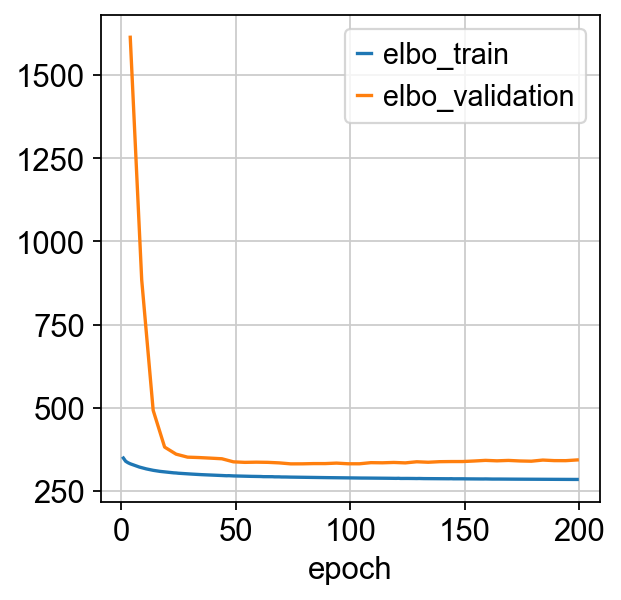

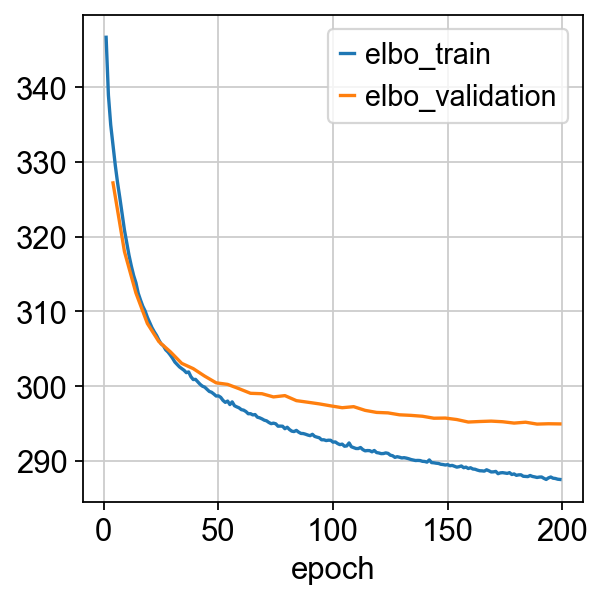

In [53]:
plotTrainingHistory(modelvamp)
plotTrainingHistory(modelsdpr)

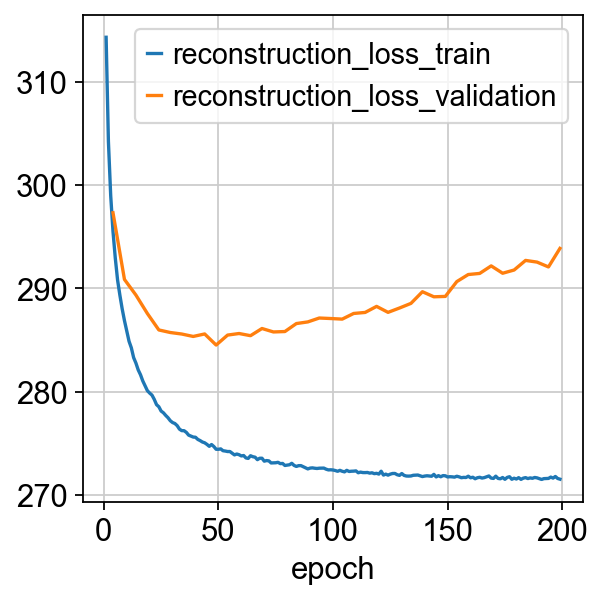

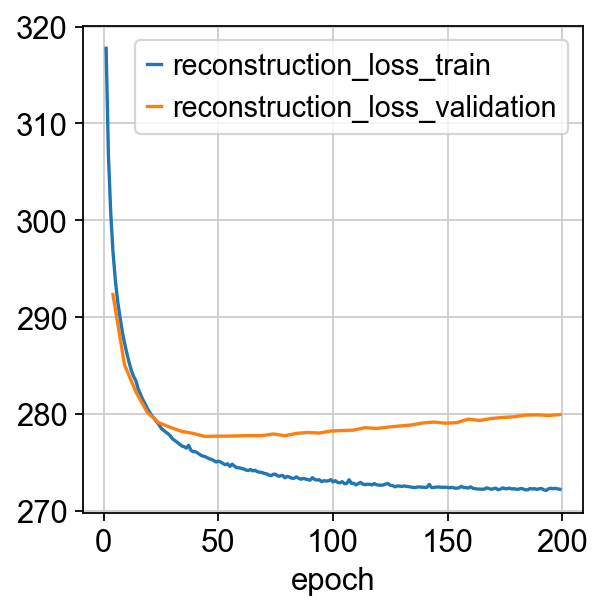

In [56]:
plotReconstructionLoss(modelvamp)
plotReconstructionLoss(modelsdpr)

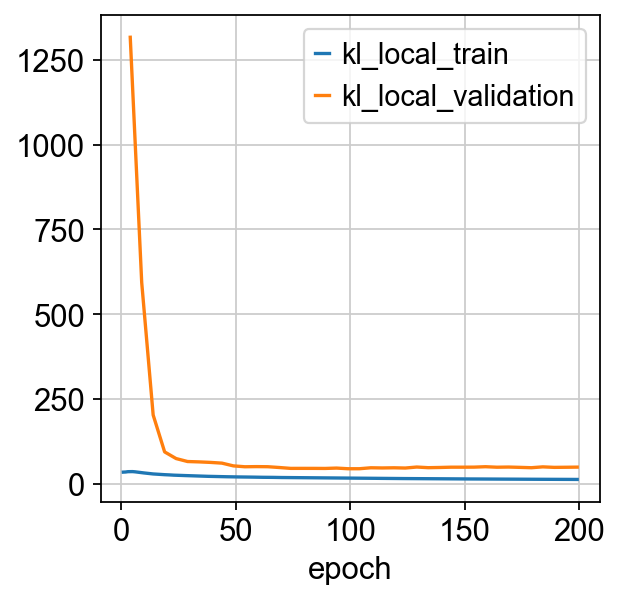

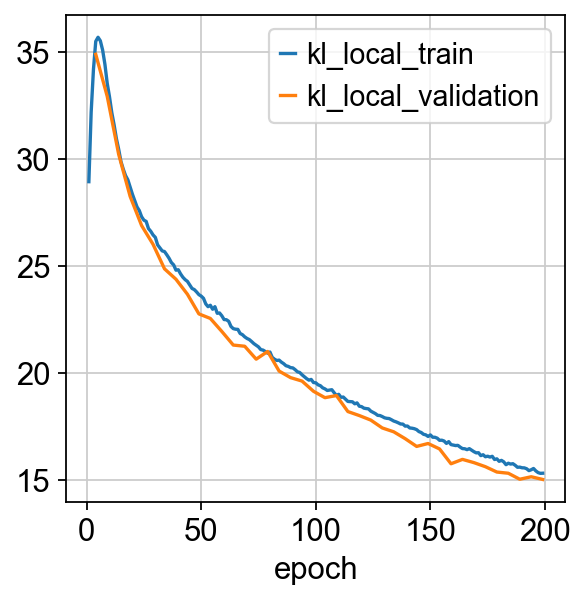

In [54]:
plotKLLocalLoss(modelvamp)
plotKLLocalLoss(modelsdpr)

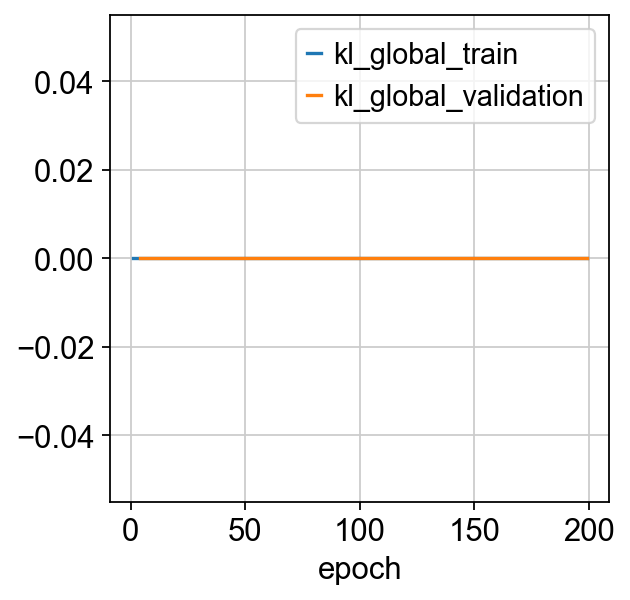

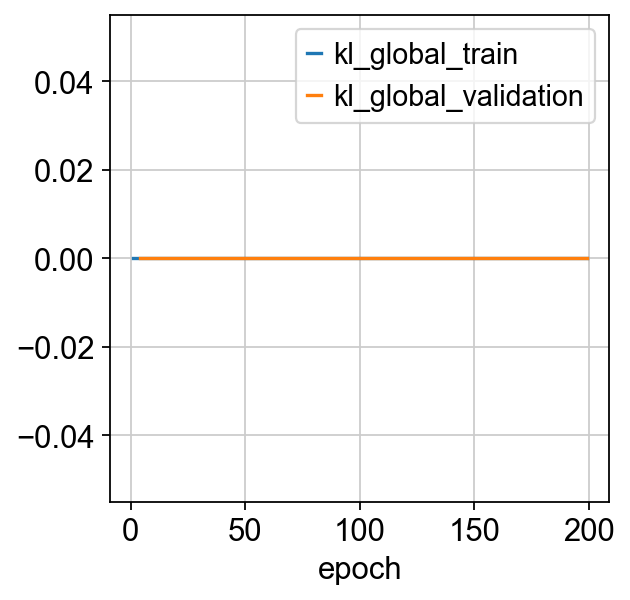

In [55]:
plotKLGlobalLoss(modelvamp)
plotKLGlobalLoss(modelsdpr)

In [10]:
modelmog = trainModel(adata,prior="mixofgaus",max_epochs=100,save="models/mgprior100")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 100/100: 100%|██████████| 100/100 [07:27<00:00,  4.20s/it, v_num=1, train_loss_step=373, train_loss_epoch=277]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [07:27<00:00,  4.47s/it, v_num=1, train_loss_step=373, train_loss_epoch=277]


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


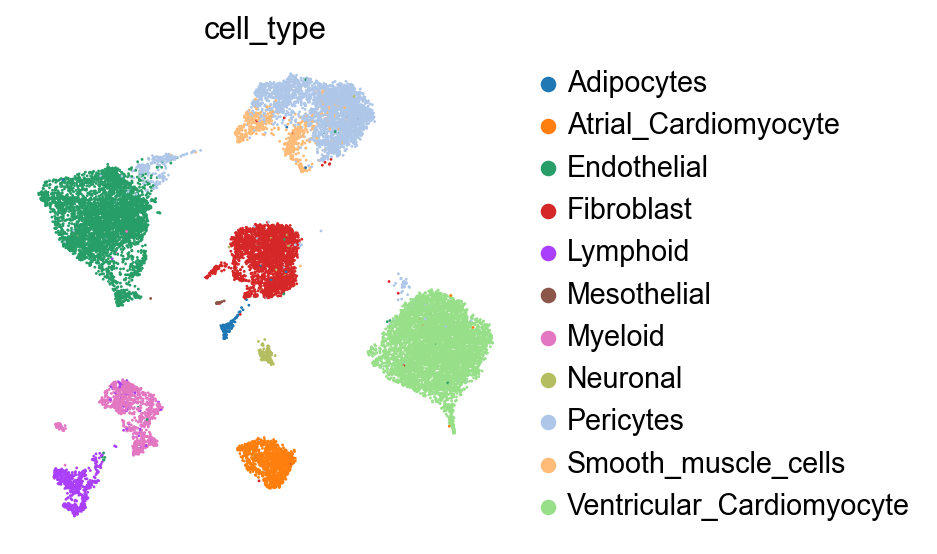

/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Applications/Anaconda/anaconda3/envs/scvi-tools-dev-n/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


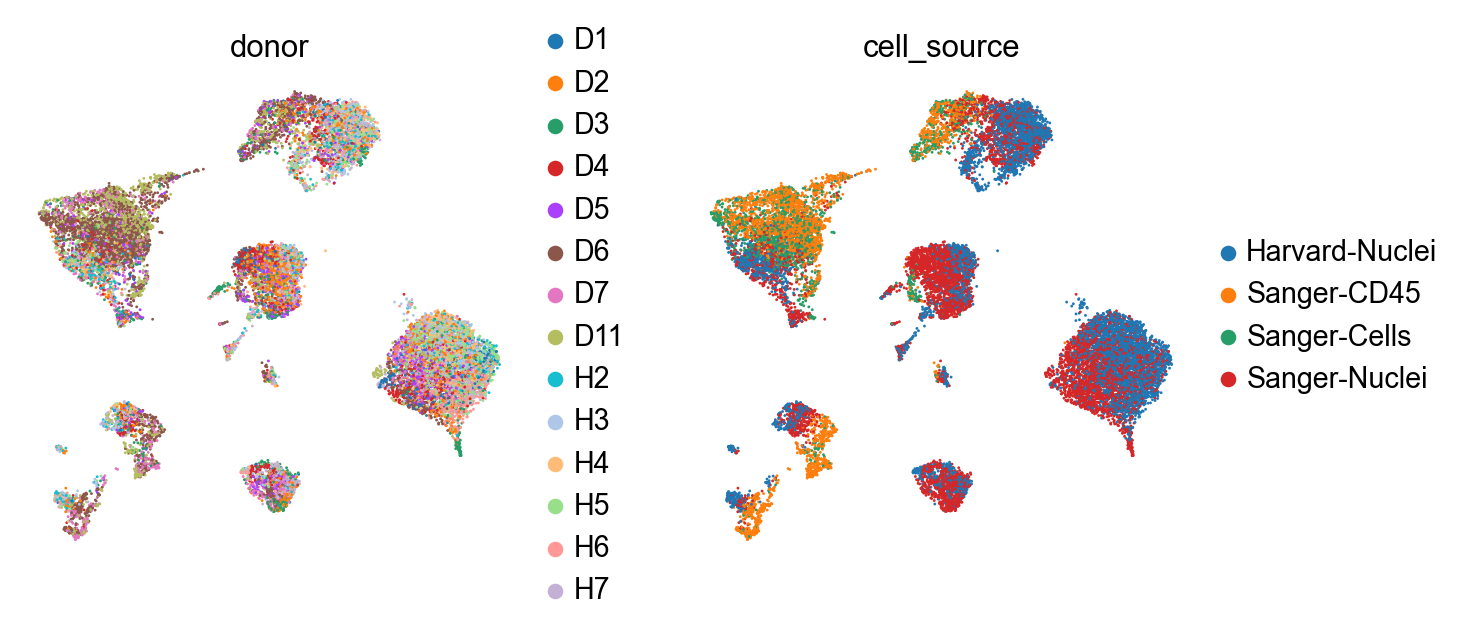

In [12]:
umapVisualization(modelmog,adata)

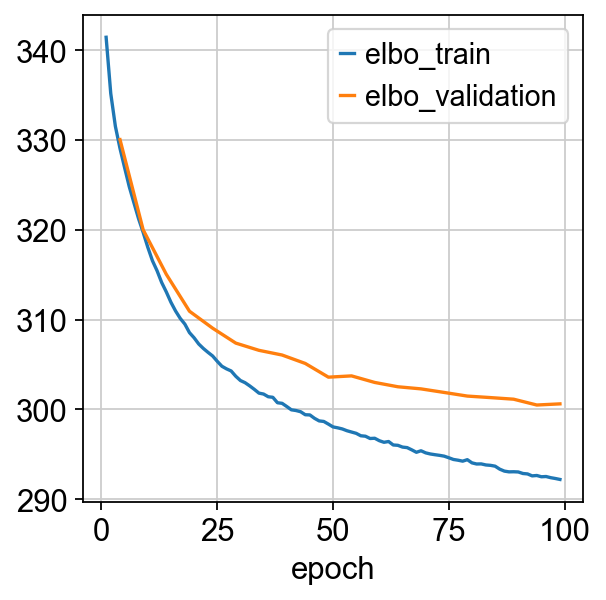

In [13]:
plotTrainingHistory(modelmog)

In [18]:
modelmog.module.prior.description()

'Mixture of Gaussians with k: 100Prior with means: Parameter containing:\ntensor([[ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0.0006, -0.0079, -0.0032,  0.0018, -0.0067,\n          0.0004,  0.0048],\n        [ 0.0021,  0.0007, -0.0164, -0